In [1]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score, cross_val_predict, train_test_split, GridSearchCV
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, f1_score, precision_score, recall_score
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns; sns.set_style("dark")

In [2]:
train = pd.read_csv("../data/train_small.csv")
test = pd.read_csv("../data/test_fe.csv")

In [3]:
train.head()

,pregnancy_occurence,glucose_concentration,blood_pressure,triceps_foldness,serum_insulin,bmi,predigree_function,age,target
0,0.000000,0.432161,0.557377,0.507937,0.000000,0.533532,0.068318,0.066667,0.0
1,0.000000,0.587940,0.655738,0.492063,0.062648,0.673621,0.004697,0.050000,0.0
2,0.117647,0.638191,0.377049,0.333333,0.395981,0.512668,0.041845,0.016667,0.0
3,0.235294,0.572864,0.524590,0.000000,0.000000,0.430700,0.020495,0.050000,0.0
4,0.176471,0.437186,0.491803,0.285714,0.000000,0.324888,0.156277,0.000000,0.0


In [4]:
x_train_use, y_train_use = train.drop("target", axis = 1), train["target"]

In [5]:
#x_train_use = x_train_use.drop_duplicates().reset_index(drop=True)

In [6]:
train.shape

(491, 9)

In [7]:
x_train, x_val, y_train, y_val = train_test_split(x_train_use, y_train_use, train_size=0.8, random_state = 42)

In [8]:
x_train.shape, y_train.shape

((392, 8), (392,))

### Logistic Regression

In [9]:
lr = LogisticRegression()
lr.fit(x_train, np.array(y_train).reshape(-1,1))

LogisticRegression()

In [10]:
y_pred = lr.predict(x_train)

In [11]:
f1_score(y_train, y_pred)

0.6688963210702341

In [12]:
np.linspace(0,1,10)

array([0.        , 0.11111111, 0.22222222, 0.33333333, 0.44444444,
       0.55555556, 0.66666667, 0.77777778, 0.88888889, 1.        ])

In [13]:
lr_pipeline = Pipeline([("lr", LogisticRegression(solver='saga', max_iter=5000))])
param_grid = [{"lr__C":np.linspace(0,1,10), "lr__penalty":["l1","l2", "elasticnet"]}]
grid_search = GridSearchCV(lr_pipeline, param_grid, cv = 5)

In [14]:
grid_search.fit(x_train, np.array(y_train).reshape(-1,1))

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('lr',
                                        LogisticRegression(max_iter=5000,
                                                           solver='saga'))]),
             param_grid=[{'lr__C': array([0.        , 0.11111111, 0.22222222, 0.33333333, 0.44444444,
       0.55555556, 0.66666667, 0.77777778, 0.88888889, 1.        ]),
                          'lr__penalty': ['l1', 'l2', 'elasticnet']}])

In [15]:
grid_search.best_params_

{'lr__C': 0.6666666666666666, 'lr__penalty': 'l1'}

In [16]:
model = grid_search.best_estimator_

In [17]:
model.fit(x_train, y_train)

Pipeline(steps=[('lr',
                 LogisticRegression(C=0.6666666666666666, max_iter=5000,
                                    penalty='l1', solver='saga'))])

In [18]:
y_pred = model.predict(x_train)

In [19]:
f1_score(y_train, y_pred)

0.6907894736842105

In [20]:
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

         0.0       0.76      0.85      0.80       227
         1.0       0.76      0.64      0.69       165

    accuracy                           0.76       392
   macro avg       0.76      0.74      0.75       392
weighted avg       0.76      0.76      0.76       392



In [21]:
train["target"].value_counts()

0.0    278
1.0    213
Name: target, dtype: int64

In [22]:
import seaborn as sns; sns.set_style("darkgrid")

In [23]:
def plot_confusion_matrix(title,conf_matrix):
    plt.figure(figsize=(8, 6))
    sns.set(font_scale=1.2)
    sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', cbar=False,
                xticklabels=['Predicted 0', 'Predicted 1'],
                yticklabels=['Actual 0', 'Actual 1'])
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title(title)
    plt.savefig("../conf/"+title+".png")
    plt.show()

<AxesSubplot:>

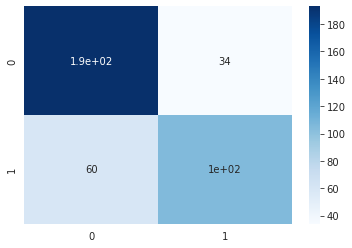

In [24]:
conf = confusion_matrix(y_train, y_pred)
sns.heatmap(conf, annot=True, cmap= "Blues")

In [25]:
y_pred_val = model.predict(x_val)

In [26]:
f1_score(y_val, y_pred_val)

0.6823529411764706

In [27]:
print(classification_report(y_val, y_pred_val))

              precision    recall  f1-score   support

         0.0       0.69      0.84      0.76        51
         1.0       0.78      0.60      0.68        48

    accuracy                           0.73        99
   macro avg       0.74      0.72      0.72        99
weighted avg       0.74      0.73      0.72        99



#### Extracting results

In [28]:
import time
start = time.time()
model.fit(x_train_use, y_train_use)
elapsed = time.time() - start

In [29]:
pred_use = model.predict(x_train_use)

In [30]:
cross_val_score(model, x_train_use, y_train_use, scoring="f1")

array([0.64864865, 0.725     , 0.73563218, 0.68292683, 0.67532468])

In [31]:
print(classification_report(y_train_use, pred_use))

              precision    recall  f1-score   support

         0.0       0.76      0.83      0.79       278
         1.0       0.74      0.66      0.70       213

    accuracy                           0.75       491
   macro avg       0.75      0.74      0.74       491
weighted avg       0.75      0.75      0.75       491



In [32]:
f1_train = f1_score(y_train_use, pred_use)
prec_train = precision_score(y_train_use, pred_use)
recall_train = recall_score(y_train_use, pred_use)

In [33]:
cols=train.columns
cols

Index(['pregnancy_occurence', 'glucose_concentration', 'blood_pressure',
       'triceps_foldness', 'serum_insulin', 'bmi', 'predigree_function', 'age',
       'target'],
      dtype='object')

In [34]:
test

,pregnancy_occurence,glucose_concentration,blood_pressure,triceps_foldness,serum_insulin,bmi,predigree_function,age,target
0,0.352941,0.492462,0.475410,0.523810,0.224586,0.506706,0.150299,0.366667,0.0
1,0.117647,0.562814,0.614754,0.507937,0.000000,0.532042,0.029889,0.000000,0.0
2,0.117647,0.542714,0.524590,0.000000,0.000000,0.459016,0.034159,0.000000,0.0
3,0.470588,0.537688,0.655738,0.000000,0.000000,0.366617,0.332195,0.216667,0.0
4,0.411765,0.683417,0.737705,0.000000,0.000000,0.445604,0.056362,0.483333,0.0
...,...,...,...,...,...,...,...,...,...
149,0.529412,0.829146,0.721311,0.000000,0.000000,0.453055,0.095645,0.466667,1.0
150,0.058824,0.386935,0.459016,0.476190,0.066194,0.496274,0.500854,0.050000,0.0
151,0.470588,0.477387,0.590164,0.000000,0.000000,0.548435,0.173783,0.600000,0.0
152,0.117647,0.733668,0.573770,0.603175,0.425532,0.417288,0.110589,0.133333,1.0


In [35]:
x_test, y_test = test.drop("target", axis =1), test["target"]

In [36]:
pred_test = model.predict(x_test)

In [37]:
print(classification_report(y_test, pred_test))

              precision    recall  f1-score   support

         0.0       0.81      0.74      0.77        99
         1.0       0.59      0.69      0.64        55

    accuracy                           0.72       154
   macro avg       0.70      0.71      0.71       154
weighted avg       0.73      0.72      0.72       154



In [38]:
f1_test = f1_score(y_test, pred_test)
prec_test = precision_score(y_test, pred_test)
recall_test = recall_score(y_test, pred_test)

In [39]:
conf = confusion_matrix(y_test, pred_test)

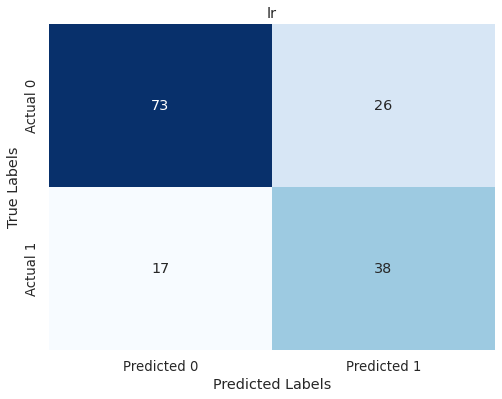

In [40]:
plot_confusion_matrix("lr",conf)

In [41]:
df = pd.DataFrame()
df["f1_test"] = [f1_test]
df["f1_train"] = f1_train
df["prec_train"] = prec_train
df["prec_test"] = prec_test
df["recall_train"] = recall_train
df["recall_test"] = recall_test
df["model"] = "Logistic Regression"
df["elapsed"] = elapsed

In [42]:
df

,f1_test,f1_train,prec_train,prec_test,recall_train,recall_test,model,elapsed
0,0.638655,0.698254,0.744681,0.59375,0.657277,0.690909,Logistic Regression,0.010675


In [43]:
df.to_csv("../results/regular/lr.csv", index=False)

In [44]:
len(test)

154